# Comparison benefit difference and covariance

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid, mean_difference
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility
from src.plotting import plot_mean, plot_median
from src.training import train
from src.distribution import FICODistribution
from src.policy import LogisticPolicy

unable to import 'smart_open.gcs', disabling that module


In [2]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.5, **util_params)
    return util

training_parameters = {    
    # 'save_path': './',
    'model':{
        'utility_function': util_func,
        'fairness_function': None,
        'fairness_gradient_function': None,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': [-3.0, 5.0]
    },
    'parameter_optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_decisions': 128 * 256
    },
    'data': {
        'distribution': FICODistribution(bias=bias, fraction_protected=0.2),
        'num_test_samples': 8192
    }
}

## Train unconstrained:

---------- Single training run for fixed lambda ----------


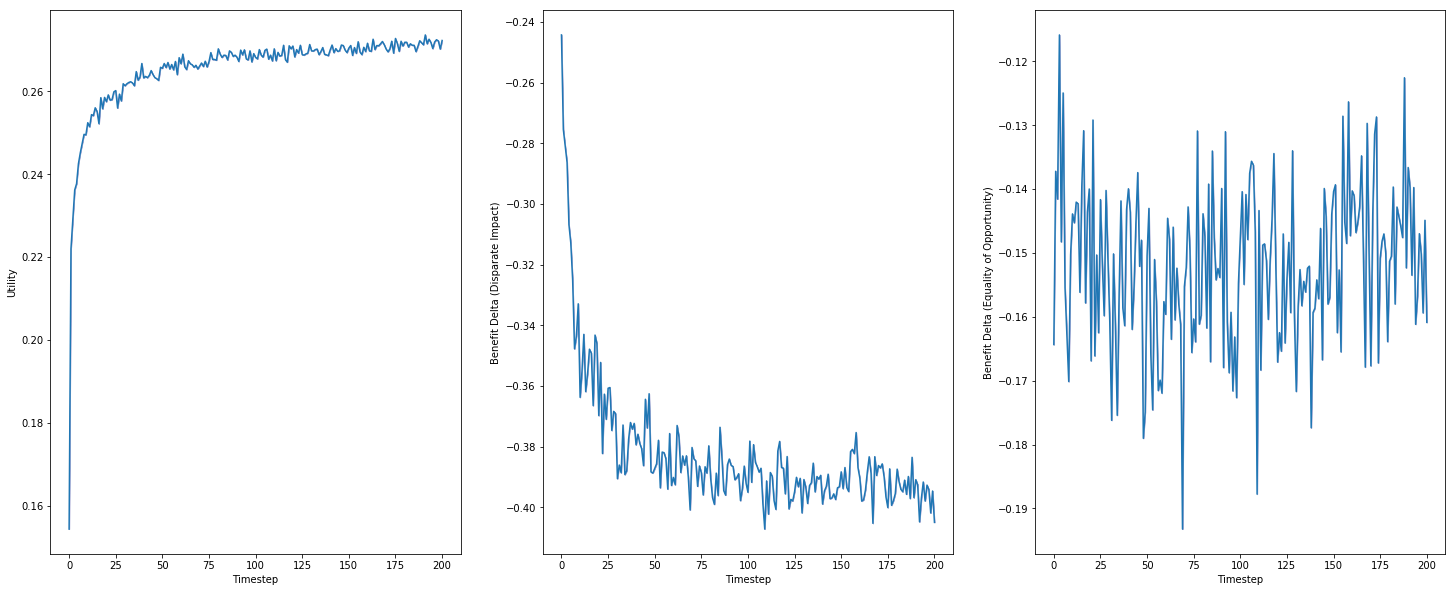

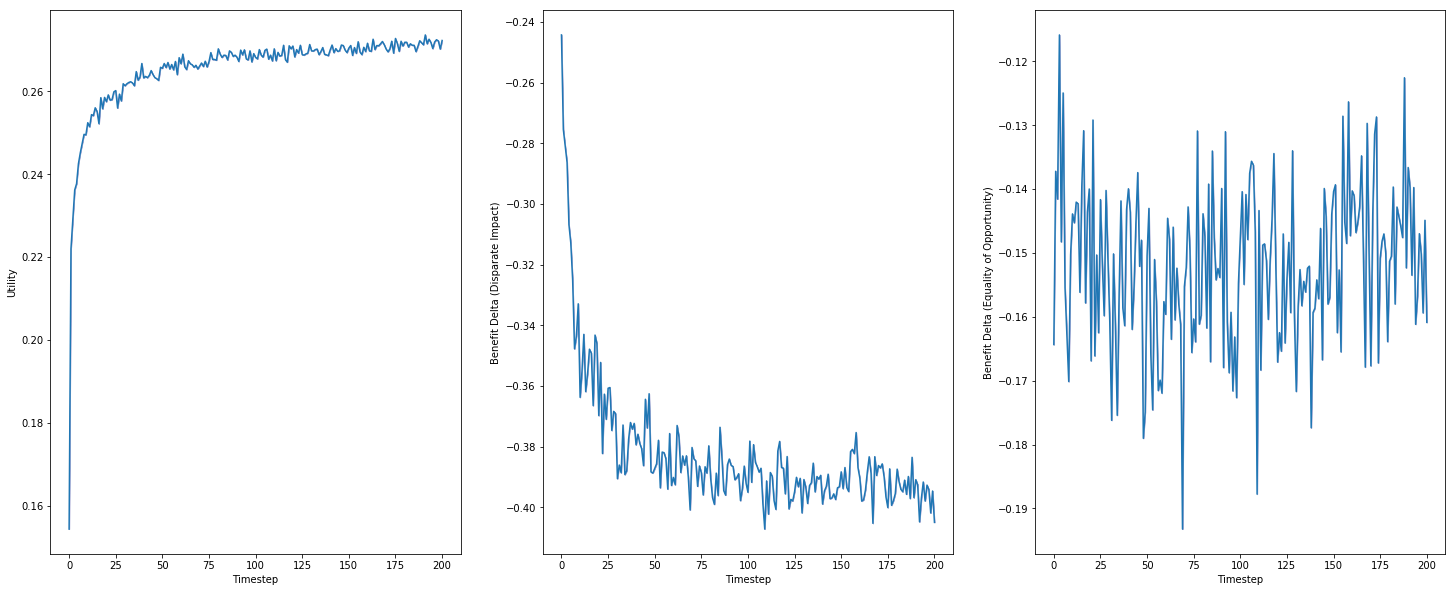

In [3]:
def fairness(**params):
    return [0.0]

training_parameters["model"]["fairness_function"] = fairness
training_parameters["model"]["fairness_gradient_function"] = fairness

training_parameters["experiment_name"] = "exp-018"
training_parameters["model"]["initial_lambda"] = 0.0

statistics, model_parameters, _ = train(training_parameters, iterations=1, asynchronous=True)

plot_mean(statistics)
plot_median(statistics)

In [4]:
def benefits(decision, s, groups=[0, 1]):
    s_0_idx = np.where(s == groups[0])
    s_1_idx = np.where(s == groups[1])

    if len(s_0_idx) == 0 or len(s_1_idx) == 0:
        return 0.0, 0.0

    target_s0 = decision[s_0_idx].mean(axis=0)
    target_s1 = decision[s_1_idx].mean(axis=0)
    
    return target_s0, target_s1
    
def calc_covariance(s, decisions):  
    mu_s = np.mean(s, axis=0)        
    covariance = (s - mu_s) * decisions
    return covariance
    

In [18]:
theta = model_parameters.dict[0][0]["theta"]
distribution = FICODistribution(0.2, True)
policy = LogisticPolicy(theta, IdentityFeatureMap(len(theta)), use_sensitive_attributes=False)

x, s, y = distribution.sample_test_dataset(1000000)
d, _ = policy(x, s)
new_s = 1 - (2 * s)
prob_s1 = len(np.where(new_s == 1)[0]) / len(new_s)
prob_sm1 = len(np.where(new_s == -1)[0]) / len(new_s)

mu_new_s = new_s.mean(axis=0)
mu_s = s.mean(axis=0)
mu_d = d.mean(axis=0)

print("==========================")
print("Mean of s \in [0,1]: {}".format(mu_s))
print("Mean of s \in [1,-1]: {}".format(mu_new_s))
print("Mean of d: {}".format(mu_d))
print("P(s=1). P(s=-1): {}, {}".format(prob_s1, prob_sm1))

benefit_s1, benefit_sm1 = benefits(d, new_s, groups=[1,-1])

print("==========================")
print("b_1, b_-1: {}, {}".format(benefit_s1, benefit_sm1))

bd = benefit_s1 - benefit_sm1
cov = np.mean(calc_covariance(new_s, None, d))
weighted_bd = prob_s1 * benefit_s1 - prob_sm1 * benefit_sm1

print("==========================")
print("Covariance of s in [1,-1] and d: {}".format(cov))
print("Benefit difference of [1, -1]: {}".format(bd))

print("==========================")
print("Weighted benefit difference of [1, -1] - mu_new_s * mu_d: {}".format(weighted_bd - (mu_new_s * mu_d)))

Mean of s \in [0,1]: [0.19985]
Mean of s \in [1,-1]: [0.6003]
Mean of d: [0.677167]
P(s=1). P(s=-1): 0.80015, 0.19985
b_1, b_-1: 0.7599362619508843, 0.34577933450087567
Covariance of s in [1,-1] and d: 0.13245564990000008
Benefit difference of [1, -1]: 0.4141569274500086
Weighted benefit difference of [1, -1] - mu_new_s * mu_d: [0.13245565]
